In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [16]:
# Define the data (excluding the "Index" column)
data = pd.read_csv('SMAI-Dataset-customer-dataset/data.csv')  # Replace 'your_data.csv' with the actual file path
data = data.iloc[:, 1:].values  # Exclude the "Index" column and convert to NumPy array

# Ensure that the data is in the correct format (num_samples, num_features)
print(data.shape)

means = np.mean(data, axis=0)
stds = np.std(data, axis=0)

# Standardize the data
data = (data - means) / stds


(2000, 7)


used chatgpt

In [17]:
import numpy as np
from scipy.stats import multivariate_normal

class GMM:
  def __init__(self, num_components):
    self.num_components = num_components

  def fit(self, data, num_iterations=100, tol=1e-4):
    num_samples, num_features = data.shape

    # Initialize parameters
    self.means = np.random.randn(self.num_components, num_features)
    self.covariances = [np.identity(num_features) for _ in range(self.num_components)]
    self.weights = np.ones(self.num_components) / self.num_components
    
    for iteration in range(num_iterations):
        # E-step
      responsibilities = self._expectation(data)

      # M-step
      self._maximization(data, responsibilities)

      # Calculate log-likelihood
      log_likelihood = self._calculate_likelihood(data)
      # print(f"Iteration {iteration + 1}: Log-Likelihood = {log_likelihood}")

      # Check for convergence
      if iteration > 0 and abs(log_likelihood - prev_log_likelihood) < tol:
        break

      prev_log_likelihood = log_likelihood

  def _expectation(self, data):
    responsibilities = np.zeros((data.shape[0], self.num_components))
    for k in range(self.num_components):
      responsibilities[:, k] = self.weights[k] * multivariate_normal.pdf(data, self.means[k], self.covariances[k])
    responsibilities /= responsibilities.sum(axis=1, keepdims=True)
    return responsibilities

  def _maximization(self, data, responsibilities, regularization=1e-6):
    for k in range(self.num_components):
      Nk = responsibilities[:, k].sum()
      self.means[k] = np.dot(responsibilities[:, k], data) / Nk
      self.covariances[k] = (np.dot(responsibilities[:, k] * (data - self.means[k]).T, (data - self.means[k])) / Nk) + regularization * np.identity(data.shape[1])
      self.weights[k] = Nk / data.shape[0]

  def _calculate_likelihood(self, data):
    likelihoods = np.zeros(data.shape[0])
    for k in range(self.num_components):
      likelihoods += self.weights[k] * multivariate_normal.pdf(data, self.means[k], self.covariances[k])
    return np.log(likelihoods).sum()
    
  def calculate_likelihoods(self, samples):
    likelihoods = np.zeros((samples.shape[0], self.num_components))
    for k in range(self.num_components):
      likelihoods[:, k] = self.weights[k] * multivariate_normal.pdf(samples, self.means[k], self.covariances[k])
    return likelihoods

  def get_membership_values(self, samples):
    responsibilities = np.zeros((samples.shape[0], self.num_components))
    for k in range(self.num_components):
      responsibilities[:, k] = self.weights[k] * multivariate_normal.pdf(samples, self.means[k], self.covariances[k])
    responsibilities /= responsibilities.sum(axis=1, keepdims=True)
    return responsibilities
  
  def aic(self, data):
    num_samples = data.shape[0]
    num_features = data.shape[1]
    num_params = self.num_components * (num_features + num_features*(num_features+1)//2 + 1)
    log_likelihood = self._calculate_likelihood(data)
    aic_score = 2 * num_params - 2 * log_likelihood
    return aic_score

  def bic(self, data):
    num_samples = data.shape[0]
    num_features = data.shape[1]
    num_params = self.num_components * (num_features + num_features*(num_features+1)//2 + 1)
    log_likelihood = self._calculate_likelihood(data)
    bic_score = num_params * np.log(num_samples) - 2 * log_likelihood
    return bic_score
  
  def predict(self, samples):
    responsibilities = self._expectation(samples)
    return np.argmax(responsibilities, axis=1)


In [18]:
if __name__ == "__main__":
  results = {'Components': [], 'Log-Likelihood': [], 'AIC': [], 'BIC': []}
  for i in range(1, 21):
    gmm = GMM(num_components=i)
    gmm.fit(data)
    results['Components'].append(i)
    results['Log-Likelihood'].append(gmm._calculate_likelihood(data))
    results['AIC'].append(gmm.aic(data))
    results['BIC'].append(gmm.bic(data))
results = pd.DataFrame(results)
print(results)

    Components  Log-Likelihood           AIC           BIC
0            1   -16863.344267  33798.688534  34000.321022
1            2   -10161.167787  20466.335574  20869.600551
2            3     4803.292587  -9390.585175  -8785.687709
3            4     8897.779699 -17507.559398 -16701.029443
4            5     9404.298609 -18448.597217 -17440.434774
5            6     9965.311074 -19498.622147 -18288.827216
6            7    15661.819195 -30819.638390 -29408.210971
7            8    10583.929726 -20591.859452 -18978.799544
8            9    17090.592889 -33533.185778 -31718.493381
9           10    16473.292918 -32226.585835 -30210.260950
10          11    19511.666103 -38231.332206 -36013.374832
11          12    23382.649286 -45901.298573 -43481.708710
12          13    14447.948786 -27959.897572 -25338.675221
13          14    28159.419675 -55310.839349 -52487.984509
14          15    24466.110614 -47852.221229 -44827.733901
15          16    22945.317262 -44738.634524 -41512.5147

#### Log-Likelihood:

- As you increase the number of components, the log-likelihood of the data is expected to increase. More components allow the model to fit the data more closely, resulting in a higher likelihood.
#### AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion):

- Both AIC and BIC are model selection criteria that balance model fit and complexity. Lower AIC and BIC values indicate better models.
- Initially, AIC and BIC may decrease as you increase the number of components because the model can better fit the data. However, they will start to increase again once overfitting occurs.
#### Optimal Number of Components:

- The optimal number of components is typically chosen based on AIC, BIC, or cross-validation. It is the number of components that minimizes AIC or BIC (or maximizes cross-validation scores).
- The optimal number of components should represent the underlying structure of your data. It might correspond to the number of distinct clusters or patterns in the customer dataset.
#### Visualizations:

- Visualizations of log-likelihood, AIC, and BIC as functions of the number of components can help you identify the "elbow point" where the metrics level off. This point often corresponds to the optimal number of components.

#### Task 2: Find the optimal number of components

In [19]:
data = load_wine().data

scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)

In [20]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

In [21]:
gmm = GMM(num_components=3)
gmm.fit(X_scaled)
gmm_labels = gmm.predict(X_scaled)

print(gmm_labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 2 0 2 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 1 0 0 1 1 0 1 2 1 1
 2 1 1 1 0 1 2 2 1 1 2 2 1 1 1 1 1 1 1 2 2 0 1 2 2 1 1 2 2 2 2 1 2 1 0 2 0
 2 1 1 1 1 2 1 1 2 2 1 1 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [22]:
bic_values = []
aic_values = []

bic_values_orig = []
aic_values_orig = []

# Try different numbers of components (clusters) for GMM
n_components_range = range(1, 101)
for n_components in n_components_range:
    gmm = GMM(num_components=n_components)
    gmm.fit(X_scaled)
    bic_values.append(gmm.bic(X_scaled))
    aic_values.append(gmm.aic(X_scaled))
    
    gmm_orig = GaussianMixture(n_components=n_components)
    gmm_orig.fit(X_scaled)
    bic_values_orig.append(gmm_orig.bic(X_scaled))
    aic_values_orig.append(gmm_orig.aic(X_scaled))

# Find the optimal number of components based on BIC and AIC
optimal_n_components_bic = n_components_range[np.argmin(bic_values)]
optimal_n_components_aic = n_components_range[np.argmin(aic_values)]

print(f"Optimal number of components based on BIC: {optimal_n_components_bic}")
print(f"Optimal number of components based on AIC: {optimal_n_components_aic}")

print(bic_values)
print(aic_values)

optimal_n_components_aic_orig = n_components_range[np.argmin(aic_values_orig)]
optimal_n_components_bic_orig = n_components_range[np.argmin(bic_values_orig)]

print(f"Optimal number of components based on BIC Original: {optimal_n_components_bic}")
print(f"Optimal number of components based on AIC Original: {optimal_n_components_aic}")

print(bic_values_orig)
print(aic_values_orig)

Optimal number of components based on BIC: 24
Optimal number of components based on AIC: 40
[5746.483684666424, 5649.926782617412, 5969.741687922289, 5957.782556176991, 6119.87532855196, 6753.838267973385, 6386.346857959019, 6511.5269764589, 5901.021553878303, 5975.750943837753, 6222.732891867446, 6611.705367689477, 6730.294029200886, 6037.117516929674, 6390.276635007446, 5828.822795347511, 5348.259808198474, 5983.42783054779, 5819.567922318469, 4956.3333962961215, 5192.683720461573, 4475.529471539196, 4743.411852631811, 3693.948844427341, 4043.7107447815342, 4165.514892442323, 4509.125866459872, 4069.780118855624, 6020.068345067744, 4508.725447269271, 4122.483051475221, 5550.157262437984, 5164.699476532762, 5916.045744543491, 6884.57820429164, 6467.944401499597, 6606.965401402307, 5719.195765470546, 7096.003316934295, 5559.181473514065, 6247.023817911961, 6729.520648169138, 6787.071255304869, 7673.523910682337, 7466.83711064075, 7750.269255015057, 8925.373437945345, 9457.348958098031,

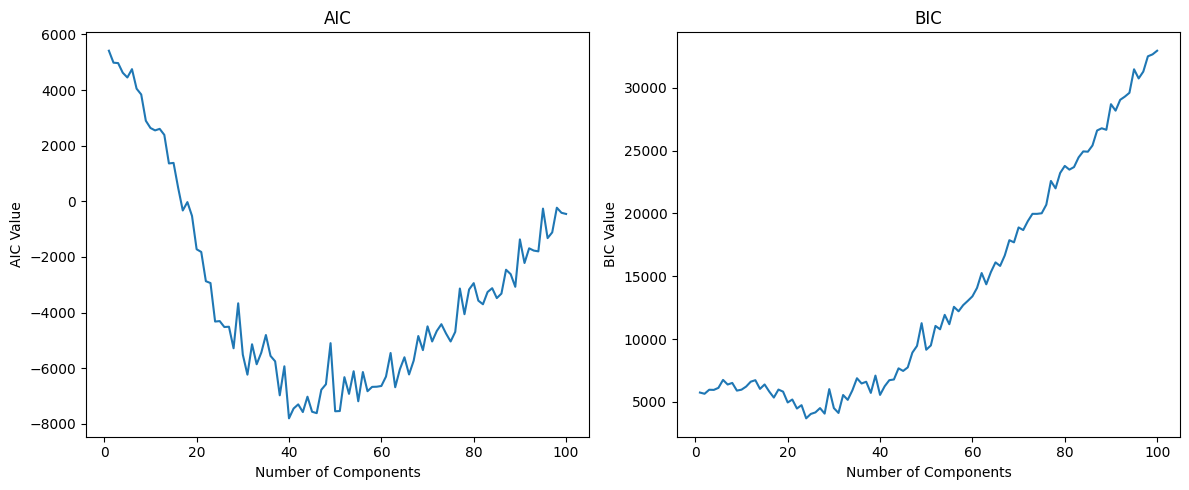

In [23]:
n_components_range = range(1, 101)

# Plot AIC values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(n_components_range, aic_values)
plt.title('AIC')
plt.xlabel('Number of Components')
plt.ylabel('AIC Value')

# Plot BIC values
plt.subplot(1, 2, 2)
plt.plot(n_components_range, bic_values)
plt.title('BIC')
plt.xlabel('Number of Components')
plt.ylabel('BIC Value')

plt.tight_layout()
plt.show()

In [24]:
kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
gmm_silhouette = silhouette_score(X_scaled, gmm_labels)

print(f"Silhouette Score for K-Means: {kmeans_silhouette}")
print(f"Silhouette Score for GMM: {gmm_silhouette}")

Silhouette Score for K-Means: 0.2848589191898987
Silhouette Score for GMM: 0.1509564320711255


#### In my results:

- The Silhouette Score for K-Means is 0.2848, which is relatively close to 1. This indicates that the K-Means clustering has produced relatively well-separated clusters.

- The Silhouette Score for GMM is 0.1509, which is lower than that of K-Means. This suggests that the GMM clustering may have resulted in clusters that are less well-separated compared to K-Means.

- The choice between K-Means and GMM can depend on the nature of your data and the specific goals of your analysis. K-Means tends to produce more compact, spherical clusters, while GMM can model more complex cluster shapes and account for covariance between features.

- In your case, it appears that K-Means is providing better separation between clusters according to the Silhouette Score metric. However, it's important to consider other factors and domain knowledge when selecting the appropriate clustering algorithm for your specific problem.

#### Reducing Dimensionality with PCA

In [25]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

gmm = GMM(num_components=4)
gmm.fit(X_pca)
gmm_labels = gmm.predict(X_pca)

gmm = GaussianMixture(n_components=4, random_state=42, n_init=10)
gmm_labels_orig = gmm.fit_predict(X_pca)

print(gmm_labels_orig, gmm_labels, sep='\n')

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_pca)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 3 0 3 3 0 0 3 0 3 0 1
 3 0 0 0 3 3 0 3 0 2 3 3 0 0 0 0 0 0 0 3 3 1 0 3 3 3 3 0 0 0 3 0 0 0 0 3 3
 0 0 0 0 0 0 0 0 0 3 1 0 0 3 0 0 0 0 0 0 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 1 1 0 2 1 1 0 1 0 1 0 2
 1 0 1 0 2 1 0 1 0 0 1 1 0 0 0 0 0 0 0 1 1 2 0 1 1 1 1 0 0 0 1 0 1 0 1 1 1
 1 0 0 0 0 0 1 0 0 1 2 0 0 1 1 1 0 0 0 0 0 3 0 0 3 3 3 3 0 3 0 3 0 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


#### Plotting Clusters with PCA using k-means and GMM with 2 components and assuming 4 clustes

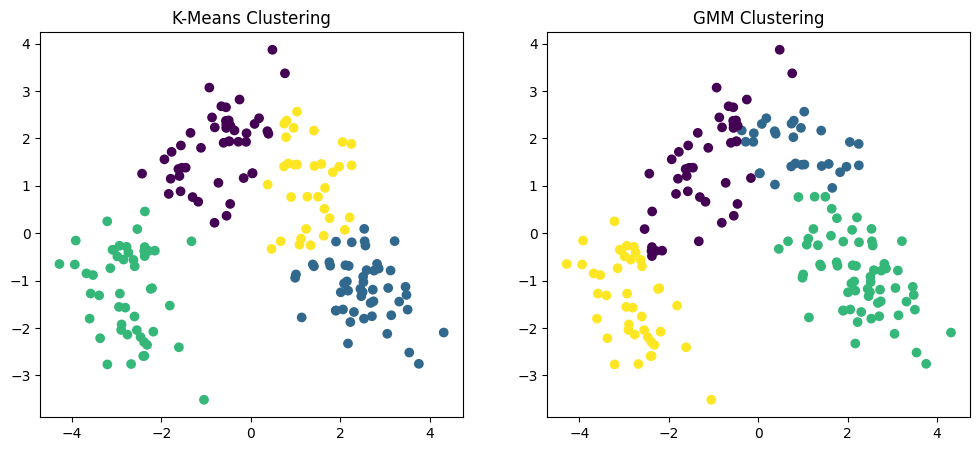

In [26]:
plt.figure(figsize=(12, 5))

# K-Means Scatter Plot
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis')
plt.title('K-Means Clustering')

# GMM Scatter Plot
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=gmm_labels, cmap='viridis')
plt.title('GMM Clustering')

plt.show()

Two graphs are plotted in which the first one is KMeans and the second one is GMM.
From these two graphs, the following observations can be inferred:
- The clusters are variable in size and shape in GMM whereas in KMeans the clusters are spherical and of equal size.
- The Silhoutte score of Kmeans is higher than that of GMM indicating Kmeans is a better clustering algorithm.
- The Boundaries of the clusters in GMM are not clearly defined whereas in KMeans they are clearly defined.